# Imports and processes firn cores from SUMUP (2024) dataset

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

from process_sumup_cores import *

from scipy.optimize import curve_fit
from scipy.optimize import fsolve, brentq

First, load all the data from the region of interest (Antarctica or Greenland). Set the paths appropriately so that it links to your own folder with sumup data.

In [3]:
# process sumup cores

data_path = "/home/nld4814/perm/cores/sumup/source/"  # Update this to your SUMup data folder
output_path = "/home/nld4814/perm/cores/sumup/processed/"  # Path to save output files (can be same as data_path)
output_prefix = "sumup_550_830_density_depths"  # Will create _greenland.csv, _antarctica.csv, and _combined.csv files
domain = "greenland"

density_df, profile_names_df, references_df = load_sumup_data(data_path, domain)


Loading SUMup data files...
Loading Greenland data only
Loaded 1,976,302 greenland density measurements
Loaded 4229 profile names
Loaded 271 references


We can select cores from the density dataset `density_df` by profile_key -- this gives us all the measurements of depth and density; the other information is identical. We can then plot it, and use the core's name for it's title by searching for the `profile_key` in the `profile_names_df` dataframe.

Text(0.5, 0, 'Density [kg/m3]')

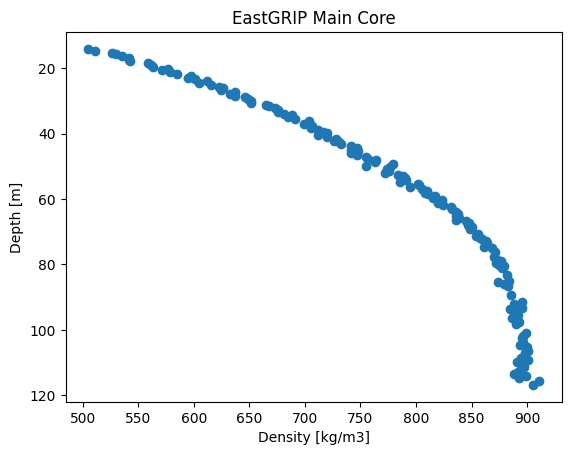

In [4]:
key = 2864
prof = density_df[density_df["profile_key"]==key]
plt.plot(prof["density"],prof["midpoint"], 'o')
plt.title(profile_names_df.loc[key]["profile"])
plt.gca().invert_yaxis()
plt.ylabel("Depth [m]")
plt.xlabel("Density [kg/m3]")

There are a few ways of going about choosing depth to 550 kg/m3 and 830 kg/m3. We are going to take the easiest option: look for the first instance where the depth exceeds the target density, and we interpolate between that point and the point previous to get the depth. We could also fit a curve to the depth-density profile, and then select a depth from there. We cannot just use a built in funciton like `interp_1d` because the densities often do not monotonically increase with depth

In [5]:
# let's simplify the structure of our dataframe so we can find the depths of the target densities more easily

prof = prof.drop(columns=['reference_key', 'method_key', 'start_depth', 'stop_depth', 'error', 'region'])
prof = prof.rename(columns={"midpoint": "depth"})
prof.head()

,profile_key,timestamp,latitude,longitude,elevation,depth,density
1976134,2864,2016-06-01,75.63,-36.0,2704.0,14.025,504.9
1976135,2864,2016-06-01,75.63,-36.0,2704.0,14.575,510.7
1976136,2864,2016-06-01,75.63,-36.0,2704.0,15.125,526.7
1976137,2864,2016-06-01,75.63,-36.0,2704.0,15.675,530.3
1976138,2864,2016-06-01,75.63,-36.0,2704.0,16.225,535.6


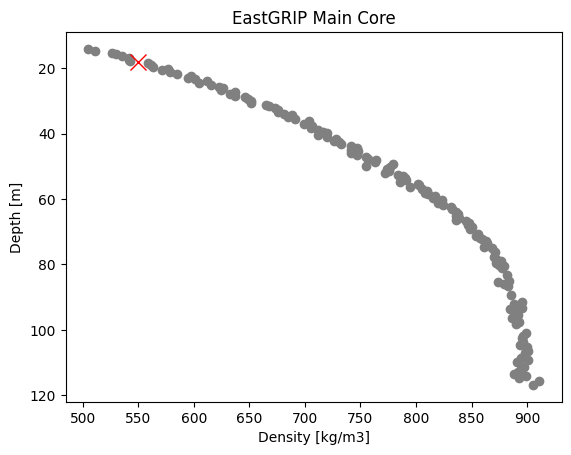

In [6]:
# an example for a target density of 550
df = prof.copy()
failed = False

target_density = 550

depth = np.array(df.depth.values)
density = np.array(df.density.values)

# Sort by depth - should monotonically increase (but density likely won't)
sort_idx = np.argsort(depth)
depth_sorted = depth[sort_idx]
density_sorted = density[sort_idx]

# Check if target density is reached
if np.max(density_sorted) < target_density:
    print("Core too shallow, do not proceed")
    failed = True
    #return np.nan

if not failed:
    # Find first point where target density is reached or exceeded
    idx = np.where(density_sorted >= target_density)[0]

    first_idx = idx[0]
    
    # If first measurement already exceeds target, interpolate previous depth is zero. we choose 350 to be the density at the surface.
    if first_idx == 0:
        prev_depth = 0
        prev_density = 350
    else:
        prev_depth = depth_sorted[first_idx - 1]
        prev_density = density_sorted[first_idx - 1]
    
    curr_depth = depth_sorted[first_idx]
    curr_density = density_sorted[first_idx]
        
    # Weighted interpolatation based on distance and density difference
    interpolated_depth = prev_depth + (target_density - prev_density) * (curr_depth - prev_depth) / (curr_density - prev_density)

    interpolated_depth = round(interpolated_depth,2)

    #now let's plot it and make sure it looks reasonable

    plt.plot(df["density"],df["depth"], 'o', color="grey")
    plt.plot(550, interpolated_depth, 'rx', markersize=12, label='Interpolated Depth at 550 kg/m3')
    plt.gca().invert_yaxis()
    plt.ylabel("Depth [m]")
    plt.xlabel("Density [kg/m3]")

    plt.title(profile_names_df.loc[key]["profile"])



We could also choose to fit a curve to the data and then select a density from there. In general, a logarithmic or power law fit does well with depth-density datasets.

First we define the fits we could use, and the minimization of that fit with a target (for finding the depth at target density later on)

In [7]:
def power_law(x, a, b, c):
    return a * x**b + c

def power_law_minimization(x, a, b, c, target):
    return a * x**b + c - target

def logarithmic(x, a, b, c):
    return a * np.log(x + 1) + b * x + c

def log_minimization(x, a, b, c, target):
    return a * np.log(x + 1) + b * x + c - target

models = [
    (power_law, "Power law", "a*x^b + c", 'blue'),
    (logarithmic, "Logarithmic", "a*log(x+1) + b*x + c", 'green')
]

Then we fit the model to the data. We can mask the data for >600 and >550 for finding 550 and 830 depths respectively.

In [8]:
model = models[1]
func = model[0]
color = model[3]

depth_smooth = np.linspace(depth.min(), depth.max(), 200)

fit_mask = density <= 600
popt_550, pcov = curve_fit(func, depth[fit_mask], density[fit_mask])

fit_mask = density > 550
popt_830, pcov = curve_fit(func, depth[fit_mask], density[fit_mask])

popt_whole, pcov = curve_fit(func, depth, density)

# Calculate fitted values
density_smooth_550 = func(depth_smooth, *popt_550)
density_smooth_830 = func(depth_smooth, *popt_830)
density_smooth_whole = func(depth_smooth, *popt_whole)


Now we can find the density at the target depth using the fit we just calculated

In [9]:
# Find the depth at 550 using the 550 popt
try:
    depth_at_rho_550 = brentq(
        log_minimization,
        depth.min(),
        depth.max(),
        args=(*popt_550, 550)
    )

except ValueError as e:
    
    depth_at_rho_550 = np.nan
    failed_550 = int(1)

# Find the depth at 830 using the 830 popt
try:
    depth_at_rho_830 = brentq(
        log_minimization,
        depth.min(),
        depth.max(),
        args=(*popt_830, 830)
    )
    
except ValueError as e:

    depth_at_rho_830 = np.nan
    failed_830 = int(1)

# Find the depths at 550 and 830 using the whole popt
try:
    depth_at_rho_whole_550 = brentq(
        log_minimization,
        depth.min(),
        depth.max(),
        args=(*popt_whole, 550)
    )
    #print(f"Using brentq (Logarithmic): {depth_at_rho:.2f}")
except ValueError as e:
    #print(f"brentq failed for logarithmic: {e}")
    #print("Target density might be outside the range of your data")
    depth_at_rho_whole_550 = np.nan
    failed_whole_550 = int(1)

   # Find the depths at 550 and 830 using the whole popt
try:
    depth_at_rho_whole_830 = brentq(
        log_minimization,
        depth.min(),
        depth.max(),
        args=(*popt_whole, 830)
    )
    #print(f"Using brentq (Logarithmic): {depth_at_rho:.2f}")
except ValueError as e:
    #print(f"brentq failed for logarithmic: {e}")
    #print("Target density might be outside the range of your data")
    depth_at_rho_whole_830 = np.nan
    failed_whole_830 = int(1)


And plot them

Text(0.5, 1.0, 'EastGRIP Main Core')

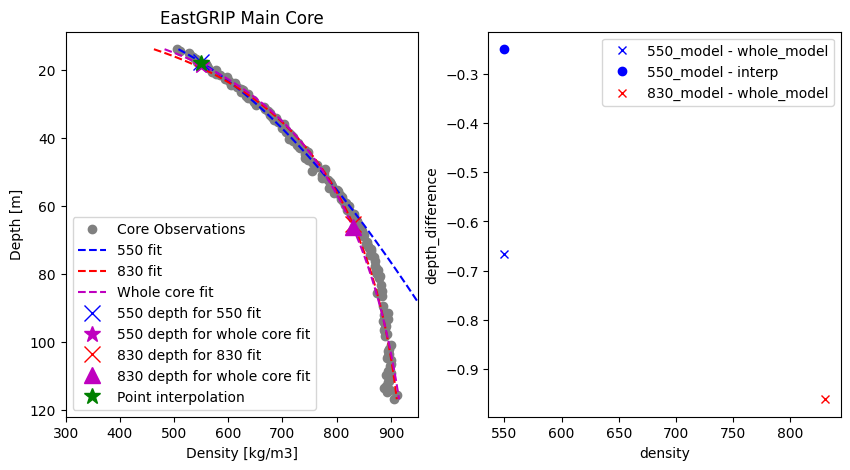

In [16]:
fig, axs = plt.subplots(1,2,figsize=(10,5))

axs[0].plot(density, depth, 'o', color='grey', label='Core Observations')
axs[0].plot(density_smooth_550, depth_smooth, '--', color="blue", label=f'550 fit')
axs[0].plot(density_smooth_830, depth_smooth, '--', color="red", label=f'830 fit')
axs[0].plot(density_smooth_whole, depth_smooth, '--', color="m", label=f'Whole core fit')
axs[0].plot(550, depth_at_rho_550, 'bx', markersize=12, label='550 depth for 550 fit')
axs[0].plot(550, depth_at_rho_whole_550, 'm*', markersize=12, label='550 depth for whole core fit')
axs[0].plot(830, depth_at_rho_830, 'rx', markersize=12, label='830 depth for 830 fit')
axs[0].plot(830, depth_at_rho_whole_830, 'm^', markersize=12, label='830 depth for whole core fit')
axs[0].plot(550, interpolated_depth, 'g*', markersize=12, label='Point interpolation')

axs[1].plot(550,depth_at_rho_550-depth_at_rho_whole_550, 'bx',label="550_model - whole_model")
axs[1].plot(550,depth_at_rho_550-interpolated_depth, 'bo',label="550_model - interp")
axs[1].plot(830,depth_at_rho_830-depth_at_rho_whole_830, 'rx',label="830_model - whole_model")
axs[1].set_xlabel('density')
axs[1].set_ylabel('depth_difference')
axs[1].legend()

axs[0].legend()
axs[0].invert_yaxis()
axs[0].set_ylabel("Depth [m]")
axs[0].set_xlabel("Density [kg/m3]")
axs[0].set_xlim(300, 950)

axs[0].set_title(profile_names_df.loc[key]["profile"])


## Now we can do the whole sumup processing! The data paths should be set in `process_sumup_cores.py` and will save automatically.

In [102]:
#do the sumup processing
        # Load data
#density_df, profile_names_df, references_df = load_sumup_data(data_path, domain)
#df = pd.read_csv("../temp/sumup_results_partial.csv")
# Process cores
results_df = process_cores_sumup(density_df, profile_names_df, references_df, depth_dependence=True, do_plot=True)
#results_df.to_csv("../data/temp/sumup_results_partial.csv")


Processing individual cores...
Processing Key: 34....

Model fitting failed for 550
Model fitting failed for 830
Processing FA13B....

Model fitting failed for 550
Model fitting failed for 830
Processing PARCA_6348_1998....

  - Target density out of range (830 not in [365.559, 777.586])
Model fitting failed for 550
Processing PARCA_SDOMEA_1997....

  - Target density out of range (830 not in [336.6, 624.5])
Processing PARCA_6345_1998....

  - Target density out of range (830 not in [350.72, 580.982])
Processing PARCA_NDYE3A&B_1997....

  - Target density out of range (830 not in [360.8, 610.6])
Processing PARCA_6642B_1998....

  - Target density out of range (830 not in [301.843, 608.55])
Processing PARCA_6745_1998....

  - Target density out of range (830 not in [355.1, 584.8])
Model fitting failed for 550
Processing PARCA_6841_1998....

  - Target density out of range (830 not in [333.228, 557.739])
  - Root finding failed for 550.
Processing PARCA_6839_1998....

  - Target density 

In [ ]:
# now we want to do some cleanup -- attempt to refit the profiles that have no 550 or 830 values
fit_again_names = ["ACT10A", "ACT11C", "ACT11D", "Dye 2 (Raven) Core A", "Site J"]
fit_again_keys_sel = [562] + results_df[results_df["core_name"].isin(fit_again_names)].profile_key.to_list()
fit_again_keys = fit_again_keys_sel + results_df[(results_df["depth_to_550"].isna()) | (results_df["depth_to_830"].isna())].profile_key.to_list()

fit_again_density = density_df[density_df["profile_key"].isin(fit_again_keys)]
fit_again_results_df = process_cores_sumup(fit_again_density, profile_names_df, references_df, depth_dependence=False, do_plot=True)

# only fills in new fit_again (whole profile) depths where whole density fit r2 > 0.8 AND no depth-dependent value was found
new_550_df = fit_again_results_df[~fit_again_results_df["depth_to_550"].isna()].copy()
new_830_df = fit_again_results_df[~fit_again_results_df["depth_to_830"].isna()].copy()

for idx, row in results_df.iterrows():

    if np.isin(row["profile_key"],new_550_df["profile_key"]) & np.isnan(row["depth_to_550"]):

        new_depth = new_550_df.depth_to_550[new_550_df["profile_key"]==row["profile_key"]].values[0]
        results_df.loc[idx,"depth_to_550"] = row.depth_to_550
    
    if (np.isin(row["profile_key"],new_830_df["profile_key"])) & np.isnan(row["depth_to_830"]):
        
        new_depth = new_830_df.depth_to_830[new_830_df["profile_key"]==row["profile_key"]].values[0]
        results_df.loc[idx,"depth_to_830"] = row.depth_to_830

# # also pull in data from the new fits for hand selected cores that were fit with the depth-dependence scheme
good_whole_fits = ["ACT10A", "ACT10B", "ACT11A", "ACT11C", "ACT11D", "Dye 2 (Raven) Core A"]
good_whole_keys = [562] + results_df[results_df["core_name"].isin(fit_again_names)].profile_key.to_list()

for idx, row in results_df.iterrows():

    # if one of the selected cores
    if np.isin(row['profile_key'],good_whole_keys):

        if np.isin(row['profile_key'], new_550_df['profile_key']):
            new_depth_550 = new_550_df.depth_to_550[new_550_df['profile_key']==row['profile_key']].values[0]
            if ~np.isnan(new_depth_550):
                results_df.loc[idx,"depth_to_550"] = new_depth_550

        if np.isin(row['profile_key'], new_830_df['profile_key']):
            new_depth_830 = new_830_df.depth_to_830[new_830_df['profile_key']==row['profile_key']].values[0]
            if ~np.isnan(new_depth_830):
                results_df.loc[idx,"depth_to_830"] = new_depth_830

# drop hand-selected cores because bad data slips through

drop_names = ["FS2_12m"]
drop_keys = [1951,955] + results_df[results_df["core_name"].isin(drop_names)].profile_key.to_list()
drop_idxs = results_df[results_df["profile_key"].isin(drop_keys)].index.values
results_df = results_df.drop(index = drop_idxs)


# Add summary statistics
print("\nSummary:")
print(f"Total cores processed: {len(results_df)}")
print(f"Cores reaching 550 kg/m³: {results_df['depth_to_550'].notna().sum()}")
print(f"Cores reaching 830 kg/m³: {results_df['depth_to_830'].notna().sum()}")
print(f"Cores reaching both densities: {(results_df['depth_to_550'].notna() & results_df['depth_to_830'].notna()).sum()}")

Processing individual cores...
Processing Key: 34....

Model fitting failed for 550
Model fitting failed for 830
Processing FA13B....

Processing PARCA_6348_1998....

  - Target density out of range (830 not in [365.559, 777.586])
Model fitting failed for 550
Processing PARCA_SDOMEA_1997....

  - Target density out of range (830 not in [336.6, 624.5])
Processing PARCA_6345_1998....

  - Target density out of range (830 not in [350.72, 580.982])
Processing PARCA_NDYE3A&B_1997....

  - Target density out of range (830 not in [360.8, 610.6])
Processing PARCA_6642B_1998....

  - Target density out of range (830 not in [301.843, 608.55])
Processing PARCA_6745_1998....

  - Target density out of range (830 not in [355.1, 584.8])
Model fitting failed for 550
Processing PARCA_6841_1998....

  - Target density out of range (830 not in [333.228, 557.739])
  - Root finding failed for 550.
Processing PARCA_6839_1998....

  - Target density out of range (550 not in [318.835, 547.881])
  - Target de

In [104]:
# Add summary statistics
print("\nSummary:")
print(f"Total cores processed: {len(results_df)}")
print(f"Cores reaching 550 kg/m³: {results_df['depth_to_550'].notna().sum()}")
print(f"Cores reaching 830 kg/m³: {results_df['depth_to_830'].notna().sum()}")
print(f"Cores reaching both densities: {(results_df['depth_to_550'].notna() & results_df['depth_to_830'].notna()).sum()}")


Summary:
Total cores processed: 1538
Cores reaching 550 kg/m³: 113
Cores reaching 830 kg/m³: 34
Cores reaching both densities: 31


In [110]:
process_sumup_main()

Loading SUMup data files...
Loading Greenland data only
Loaded 1,976,302 greenland density measurements
Loaded 4229 profile names
Loaded 271 references
Processing individual cores...
Processing Key: 34....

Model fitting failed for 550
Model fitting failed for 830
Processing FA13B....

Model fitting failed for 550
Model fitting failed for 830
Processing PARCA_6348_1998....

  - Target density out of range (830 not in [365.559, 777.586])
Model fitting failed for 550
Processing PARCA_SDOMEA_1997....

  - Target density out of range (830 not in [336.6, 624.5])
Processing PARCA_6345_1998....

  - Target density out of range (830 not in [350.72, 580.982])
Processing PARCA_NDYE3A&B_1997....

  - Target density out of range (830 not in [360.8, 610.6])
Processing PARCA_6642B_1998....

  - Target density out of range (830 not in [301.843, 608.55])
Processing PARCA_6745_1998....

  - Target density out of range (830 not in [355.1, 584.8])
Model fitting failed for 550
Processing PARCA_6841_1998..